<a href="https://colab.research.google.com/github/Nargiz-chess/Solar_forecasting/blob/main/ConvLSTM_2_Germany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

from pandas import read_csv
import pandas as pd
import datetime as dt
import matplotlib
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path1 = '/content/drive/MyDrive/Master_thesis/Datasets/Gerdata_clean.csv'
path2 = '/content/drive/MyDrive/Master_thesis/Datasets/irradiance.csv'

In [ ]:
df1 = read_csv(path1, header =0, index_col=0) 
array = df1.values
Gerdata = array.reshape(array.shape[0]*array.shape[1], order="F")

In [ ]:
df2=read_csv(path2, header =0, index_col=0) 
df2=df2.drop("local_time", axis=1)
array2 = df2.values
weath_data = array2.reshape(array2.shape[0]*array2.shape[1])


In [ ]:
#stacking irradiance 9 times to match with each house in the datset
# weath_data = np.tile(weath_data,9)
# data= np.column_stack((Gerdata,weath_data))
data.shape
data = np.nan_to_num(data)
data = pd.DataFrame(data=data)



1095/1095 [==============================] - 54s 45ms/step - loss: 51.3384
lstm: [1.576] 1.2, 1.2, 1.2, 1.1, 1.0, 0.9, 1.6, 2.3, 2.9, 2.9, 2.1, 0.8, 1.2, 1.1, 1.2, 1.1, 1.2, 1.1


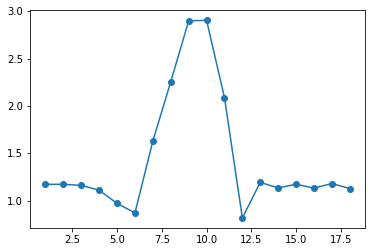

In [ ]:
from numpy import split


# split a univariate dataset into train/test sets
def split_dataset(data):
  # split into standard weeks
  train, test = data[:-90], data[-90:]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/18))
  test = array(split(test, len(test)/18))
  return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
  s = 0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row, col] - predicted[row, col])**2
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

# summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))
  
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=18):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    # Here we are dividing the data differently because we are working with a multivariate dataset (It contains more variables) 
    if out_end < len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 1, 1, 54
  n_features, n_outputs = train_x.shape[2], train_y.shape[1]
  # reshape into subsequences [samples, timesteps, rows, cols, channels]
  train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(ConvLSTM2D(filters=20, kernel_size=(1,3), activation='relu',input_shape=(n_steps, 1, n_length, n_features)))
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(20, activation='relu', return_sequences=True))
  #model.add(LSTM(20, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [samples, timesteps, rows, cols, channels]
  input_x = input_x.reshape((1, n_steps, 1, n_length, 2))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
  # fit model
  model = build_model(train, n_steps, n_length, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores,predictions


# split into train and test
train, test = split_dataset(data.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 5, 18
# define the total days to use as input
n_input = n_length * n_steps
score, scores,predictions = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# # plot scores

hours = [x for x in range(1,19)]
# hours = [str(x) for x in range(1,19)]
pyplot.plot(hours, scores, marker='o', label='lstm')
pyplot.show()
